---
# 5. Word Embedding
## 5.1 Word Embedding

In [46]:
import pandas as pd
import re
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity

In [47]:
# Load dataset
df = pd.read_csv("data/clean/lyrics_subset_1pct_clean.csv")

# nur englische Zeilen behalten
df = df[df["language_cld3"] == "en"]

# Stopwort-Liste laden
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                     # Kleinbuchstaben
    text = re.sub(r"[^a-z\s]", " ", text)   # alles außer Buchstaben & Leerzeichen → entfernen
    text = re.sub(r"\s+", " ", text).strip()  # mehrere Leerzeichen zu einem
    return text

# Nur die Lyrics-Spalte
texts = df['lyrics'].dropna().tolist()

# Tokenisierung + Stopwort-Filter
sentences = [
    [word for word in t.split() if word.lower() not in stop_words]
    for t in texts
]

# Word2Vec trainieren
model = Word2Vec(
    sentences=sentences,
    vector_size=50,
    window=5,         # Kontextfenstergröße
    min_count=2,      # ignoriert seltene Wörter
    workers=4,        # parallele Threads
    epochs=100         # Trainingsdurchläufe
)

# Ergebnisse prüfen
print("Model trained!")
print("Vocabulary size:", len(model.wv))
print("Vector size:", model.wv.vector_size)

# Beispielverwendung
word = "love"
if word in model.wv:
    print(f"\nVector for '{word}':", model.wv[word][:10])
    print("\nMost similar words to 'love':")
    print(model.wv.most_similar(word, topn=5))
else:
    print(f"'{word}' not in vocabulary.")

Model trained!
Vocabulary size: 137109
Vector size: 50

Vector for 'love': [ 0.3064794 -1.1110927  1.7893425 -1.3617563 -2.3702471  1.12527
 -5.2797422 -2.456877  -1.1252756  3.1332486]

Most similar words to 'love':
[('love,', 0.8650017380714417), ('Love', 0.8179534077644348), ('you,', 0.8125089406967163), ('loving', 0.7937344312667847), ('know', 0.7579870820045471)]


In [48]:
# Beispiel: ähnliche Wörter finden
test_word = "love"
if test_word in model.wv:
    print(f"\nMost similar to '{test_word}':")
    for w, s in model.wv.most_similar(test_word, topn=5):
        print(f"  {w:15s} {s:.3f}")
else:
    print(f"'{test_word}' not in vocabulary.")


Most similar to 'love':
  love,           0.865
  Love            0.818
  you,            0.813
  loving          0.794
  know            0.758



🔍 Finding words similar to 'like'...
Results:
  Like       ████████ 0.85
  cool       ██████ 0.69
  likе       ██████ 0.66
  Yeah       ██████ 0.64
  fucking    ██████ 0.63


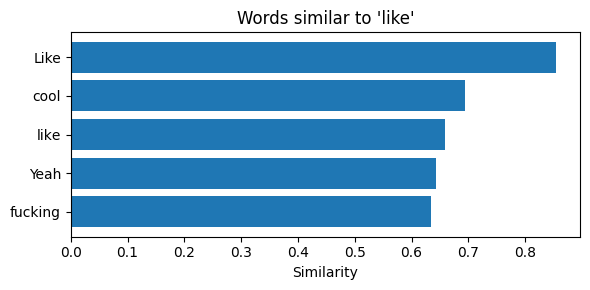


🔍 Finding words similar to 'love'...
Results:
  love,      ████████ 0.87
  Love       ████████ 0.82
  you,       ████████ 0.81
  loving     ███████ 0.79
  know       ███████ 0.76


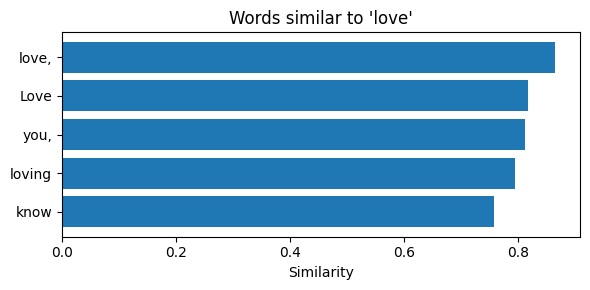


🔍 Finding words similar to 'fuck'...
Results:
  Fuck       ████████ 0.86
  fuck,      ███████ 0.74
  fucking    ███████ 0.73
  bitch      ███████ 0.71
  give       ███████ 0.70


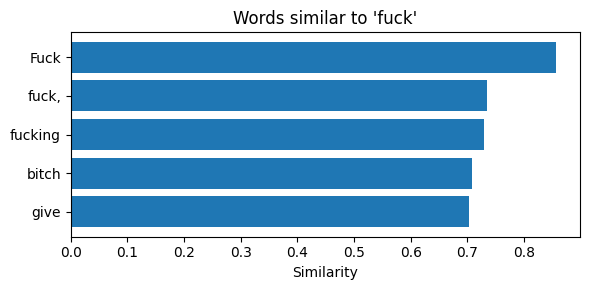

In [49]:
def find_similar_words(word, model, top_n=5):
    if word not in model.wv:
        return None, None

    similar = model.wv.most_similar(word, topn=top_n)

    words = [w for w, _ in similar]
    scores = [s for _, s in similar]

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.barh(words, scores)
    ax.set_xlabel("Similarity")
    ax.set_title(f"Words similar to '{word}'")
    ax.invert_yaxis()  # top = most similar
    fig.tight_layout()

    return similar, fig


# Example usage:
test_words = ["like", "love", "fuck"]

for word in test_words:
    print(f"\n🔍 Finding words similar to '{word}'...")
    similar, fig = find_similar_words(word, model, top_n=5)

    if similar:
        print("Results:")
        for sim_word, score in similar:
            bar = '█' * int(score * 10)
            print(f"  {sim_word:10} {bar} {score:.2f}")
        if fig:
            plt.show()   # display the bar chart
    else:
        print(f"  '{word}' not in vocabulary.")

In [50]:
def explore_embedding_space(model, n_words=30):
    vocab = list(model.wv.index_to_key)
    if len(vocab) == 0:
        raise ValueError("The model has an empty vocabulary.")
    n = min(n_words, len(vocab))
    words = vocab[:n]

    vectors = np.array([model.wv[w] for w in words])

    if vectors.shape[1] > 3:
        pca = PCA(n_components=3)
        vectors_3d = pca.fit_transform(vectors)
        axis_titles = ("PC1", "PC2", "PC3")
    else:
        vectors_3d = vectors
        axis_titles = tuple(f"Dim{i+1}" for i in range(vectors.shape[1]))

    distances = np.linalg.norm(vectors_3d, axis=1)

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=vectors_3d[:, 0],
                y=vectors_3d[:, 1] if vectors_3d.shape[1] > 1 else np.zeros_like(distances),
                z=vectors_3d[:, 2] if vectors_3d.shape[1] > 2 else np.zeros_like(distances),
                mode="markers+text",
                text=words,
                textposition="top center",
                marker=dict(
                    size=np.clip(distances * 3, 4, 24),
                    color=distances,
                    colorscale="Viridis",
                    showscale=True,
                    colorbar=dict(title="Distance"),
                ),
                hovertemplate="<b>%{text}</b><br>Distance: %{marker.color:.2f}<extra></extra>",
            )
        ]
    )

    fig.update_layout(
        title=f"Explore the Word Space (Top {n} words) — Size/Color = Distance from Origin",
        scene=dict(
            xaxis_title=axis_titles[0],
            yaxis_title=axis_titles[1] if len(axis_titles) > 1 else "",
            zaxis_title=axis_titles[2] if len(axis_titles) > 2 else "",
        ),
        height=600,
        margin=dict(l=0, r=0, t=40, b=0),
    )

    return fig

fig = explore_embedding_space(model, n_words=50)
fig.show()